In [2]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader, TensorDataset

# Data Load

In [3]:
path2img = '/home/yec23006/projects/research/KneeGrowthPlate/Knee_GrowthPlate/Images/CCC_K05_hK_FL1_s1_shift3_So.jpg'
path2platemask = '/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/plate_selection/growthplate_mask.png'
path2columnar = '/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/plate_selection/columnar_mask.png'

image = cv2.imread(path2img, cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

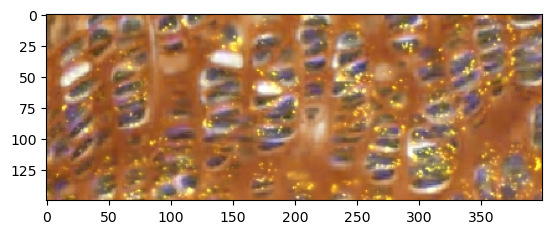

In [8]:
# possible columnar area for patch extraction
plt.imshow(image[6900:7050, 5100:5500, :])
plt.show()

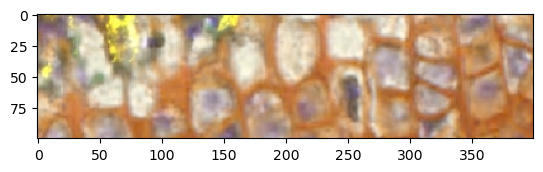

In [21]:
# possible non columnar area for patch extraction
plt.imshow(image[6700:6800, 5100:5500, :])
plt.show()

# Patch Extraction

Epoch [1/10], Loss: 0.3882
Epoch [2/10], Loss: 0.3847
Epoch [3/10], Loss: 0.3405
Epoch [4/10], Loss: 0.2269
Epoch [5/10], Loss: 0.2442
Epoch [6/10], Loss: 0.2064
Epoch [7/10], Loss: 0.4355
Epoch [8/10], Loss: 0.1596
Epoch [9/10], Loss: 0.1599
Epoch [10/10], Loss: 0.6122


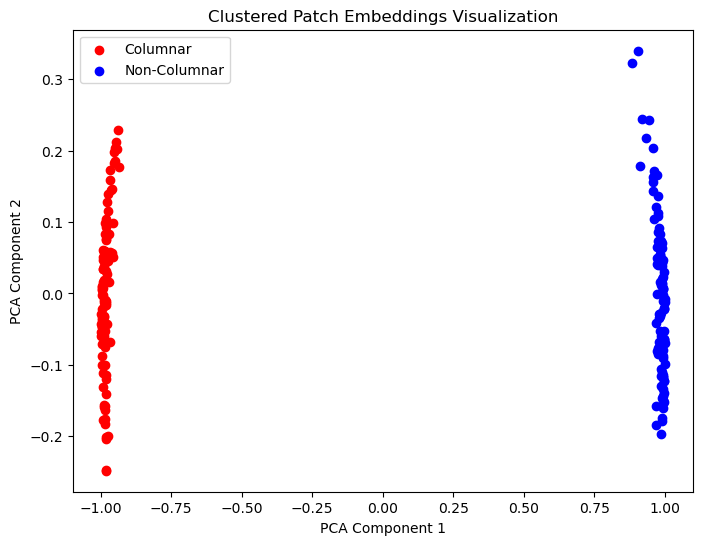

In [ ]:
def set_seed(seed=42):
    random.seed(seed)                 
    np.random.seed(seed)                
    torch.manual_seed(seed)             
    torch.cuda.manual_seed(seed)        
    torch.cuda.manual_seed_all(seed)    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Call this function before running your experiment
set_seed(42)


columnar = image[6900:7050, 5100:5500, :]
noncolumnar = image[6700:6800, 5100:5500, :]

save2 = '/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/patch_extraction'

def patch_extractor(img, num_patches=100, patch_size=64):
    h, w, _ = img.shape
    patches = []

    for _ in range(num_patches):
        y= np.random.randint(0, h - patch_size + 1)
        x= np.random.randint(0, w - patch_size + 1)
        patch = img[y:y+patch_size, x:x+patch_size, :]
        patches.append(patch)
    
    return np.array(patches)

num_patches = 100
patch_size = 64
columnar_patches = patch_extractor(columnar, num_patches, patch_size)
noncolumnar_patches = patch_extractor(noncolumnar, num_patches, patch_size)

all_patches = np.vstack((columnar_patches, noncolumnar_patches))
labels = np.array([1]*num_patches + [0]*num_patches) # 1 : columnar 0 : noncolumnar
all_patches = all_patches.astype(np.float32)/255.0

embedding_dim = 5
class ClusterEmbedding(nn.Module):
    def __init__(self, input_dim, embedding_dim, num_clusters):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256), 
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),

            nn.Linear(256, 128), 
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),

            nn.Linear(128, 64), 
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),

            nn.Linear(64, embedding_dim)
        )
        self.cluster_centers = nn.Parameter(torch.randn(num_clusters, embedding_dim))

    def forward(self, x):
        x = self.fc(x)
        x = x / torch.norm(x, dim=1, keepdim=True)  # Normalize embeddings
        return x

def contrastive_loss(embeddings, labels, cluster_centers, margin=1.0):
    intra_loss = 0  
    inter_loss = 0  
    num_clusters = cluster_centers.shape[0]
    
    # Intra-cluster compactness: Pull embeddings closer to their assigned cluster center
    for i in range(num_clusters):
        cluster_embeds = embeddings[labels == i]
        if cluster_embeds.shape[0] > 1:
            intra_loss += torch.mean(1 - torch.cosine_similarity(cluster_embeds, cluster_centers[i].unsqueeze(0)))

    # Inter-cluster separation: Push clusters apart based on similarity
    num_pairs = 0
    for i in range(num_clusters):
        for j in range(num_clusters):
            if i != j:
                similarity = torch.cosine_similarity(cluster_centers[i].unsqueeze(0), cluster_centers[j].unsqueeze(0))
                distance_penalty = torch.exp(-torch.norm(cluster_centers[i] - cluster_centers[j]))  # Exponential scaling
                inter_loss += torch.clamp(margin - similarity, min=0) * distance_penalty  # Stronger push
                num_pairs += 1

    inter_loss /= num_pairs  # Normalize
    return intra_loss + inter_loss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = patch_size * patch_size * 3
num_clusters = 2

model = ClusterEmbedding(input_dim, embedding_dim, num_clusters).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

data_tensor = torch.tensor(all_patches).to(device)
label_tensor = torch.tensor(labels, dtype=torch.long).to(device)
data_loader = DataLoader(TensorDataset(data_tensor, label_tensor), batch_size=32, shuffle=True)

num_epochs = 10
for epoch in range(num_epochs):
    for batch_data, batch_labels in data_loader:
        optimizer.zero_grad()
        embeddings = model(batch_data.view(batch_data.size(0), -1))
        loss = contrastive_loss(embeddings, batch_labels, model.cluster_centers)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

with torch.no_grad():
    embeddings = model(data_tensor.view(data_tensor.size(0), -1)).cpu().numpy()

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:num_patches, 0], reduced_embeddings[:num_patches, 1], c='r', label='Columnar')
plt.scatter(reduced_embeddings[num_patches:, 0], reduced_embeddings[num_patches:, 1], c='b', label='Non-Columnar')
plt.legend()
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Clustered Patch Embeddings Visualization")
plt.show()

# plt.figure(figsize=(8, 6))
# plt.scatter(embeddings[:num_patches, 0], embeddings[:num_patches, 1], label='Columnar')
# plt.scatter(embeddings[num_patches:, 0], embeddings[num_patches:, 1], label='Non-Columnar')
# plt.legend()
# plt.xlabel("x")
# plt.ylabel("y")
# plt.title("Clustered Patch Embeddings Visualization")
# plt.show()

# Apply on the whole image

In [7]:
def extract_object_patches(image_path, patch_size=64, stride=32, intensity_threshold=10, save_dir="/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/patch_extraction"):
    """
    Load an image, apply Otsu's thresholding, extract object-containing patches,
    and save them with their positions.
    
    Args:
        image_path (str): Path to the input image.
        patch_size (int): Size of each patch.
        stride (int): Step size for moving the patch.
        intensity_threshold (int): Minimum mean intensity to keep a patch.
        save_dir (str): Directory to save extracted patches and positions.
    
    Returns:
        filtered_patches_path (str): Path to saved filtered patches.
        filtered_positions_path (str): Path to saved patch positions.
    """
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Otsu's thresholding
    _, otsu_thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Find contours of the object
    contours, _ = cv2.findContours(otsu_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    object_mask = np.zeros_like(gray)
    cv2.drawContours(object_mask, contours, -1, (255), thickness=cv2.FILLED)
    
    # Extract patches only from object regions
    h, w, _ = image.shape
    patches, positions = [], []
    
    for y in range(0, h - patch_size + 1, stride):
        for x in range(0, w - patch_size + 1, stride):
            patch_mask = object_mask[y:y+patch_size, x:x+patch_size]
            if np.mean(patch_mask) > 128:  # Ensure patch contains object region
                patch = image[y:y+patch_size, x:x+patch_size, :]
                patches.append(patch)
                positions.append((y, x))

    print("# of patches : ", len(patches))
    # Convert to NumPy arrays
    patches = np.array(patches)
    positions = np.array(positions)
    
    # Filter out black patches
    print("Filtering out black patches")
    filtered_patches, filtered_positions = [], []
    for patch, position in zip(patches, positions):
        if np.mean(patch) > intensity_threshold:
            filtered_patches.append(patch)
            filtered_positions.append(position)
    
    print("# of filtered patches", len(filtered_patches))

    filtered_patches = np.array(filtered_patches)
    filtered_positions = np.array(filtered_positions)
    
    # Save results
    filtered_patches_path = os.path.join(save_dir, "filtered_patches.npy")
    filtered_positions_path = os.path.join(save_dir, "filtered_patch_positions.npy")
    np.save(filtered_patches_path, filtered_patches)
    np.save(filtered_positions_path, filtered_positions)
    
    
    # Visualize extracted patches
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(min(10, len(filtered_patches))):
        ax = axes[i // 5, i % 5]
        ax.imshow(cv2.cvtColor(filtered_patches[i], cv2.COLOR_BGR2RGB))
        ax.axis("off")
    plt.suptitle("Filtered Patches Containing the Object")
    plt.show()
    
    print(f"Total extracted patches: {len(filtered_patches)}")
    
    return filtered_patches_path, filtered_positions_path

# of patches :  1486
Filtering out black patches
# of filtered patches 1486


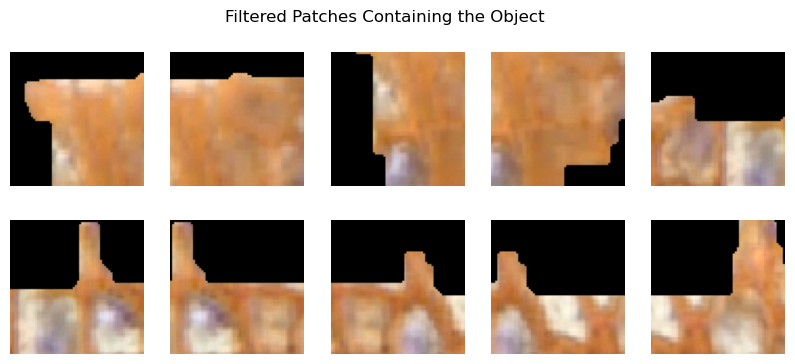

Total extracted patches: 1486


('/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/patch_extraction/filtered_patches.npy',
 '/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/patch_extraction/filtered_patch_positions.npy')

In [8]:
path2img = '/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/plate_selection/overlay_extraction.png'
extract_object_patches(path2img)

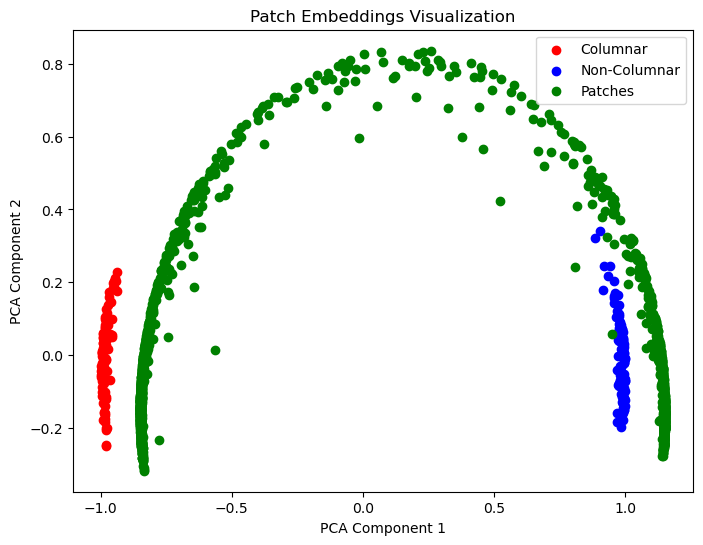

In [20]:
filtered_patches = np.load('/home/yec23006/projects/research/KneeGrowthPlate/Embedding/results/patch_extraction/filtered_patches.npy')
data_tensor_eval = torch.tensor(filtered_patches).to(device)
data_tensor_eval = data_tensor_eval.view(data_tensor_eval.shape[0], -1)
data_tensor_eval = data_tensor_eval.to(torch.float32)/255.0



model.eval()
with torch.no_grad():
    embeddings_eval = model(data_tensor_eval).cpu().numpy()

# Apply PCA for visualization (reduce to 2D space)
pca = PCA(n_components=2)
reduced_embeddings_eval = pca.fit_transform(embeddings_eval)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:num_patches, 0], reduced_embeddings[:num_patches, 1], c='r', label='Columnar')
plt.scatter(reduced_embeddings[num_patches:, 0], reduced_embeddings[num_patches:, 1], c='b', label='Non-Columnar')
plt.scatter(reduced_embeddings_eval[:, 0], reduced_embeddings_eval[:, 1], c='g', label='Patches')
plt.legend()
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Patch Embeddings Visualization")
plt.show()

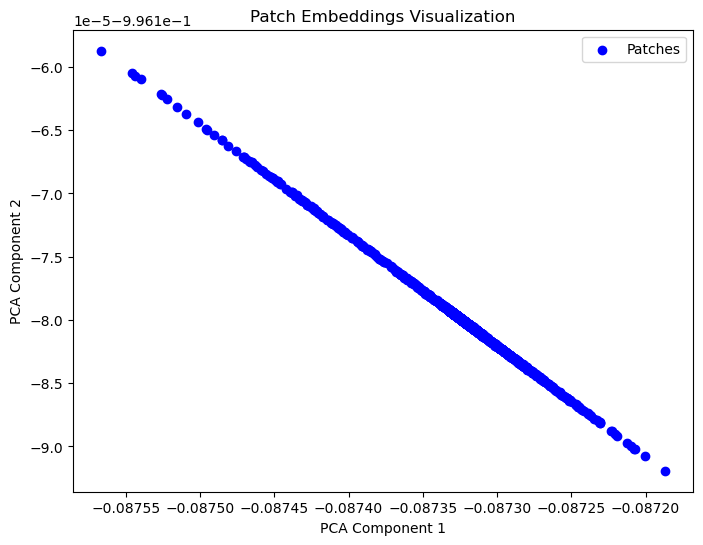

In [ ]:
object_patches = object_patches.astype(np.float32)/255.0
object_patches = np.transpose(object_patches, (0, 3, 1, 2))

data_tensor = torch.tensor(object_patches).to(device)
data_loader = DataLoader(TensorDataset(data_tensor), batch_size=16, shuffle=True)

model.eval()
with torch.no_grad():
    flattened_patches = data_tensor.reshape(data_tensor.size(0), -1)  # Flatten patches
    embeddings_eval = model(flattened_patches).cpu().numpy()

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_eval[:, 0], embeddings_eval[:, 1], c='b', label='Patches')
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Patch Embeddings Visualization")
plt.show()